In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [4]:
x, y = skds.fetch_openml("diabetes", return_X_y=True)

C:\Users\Manish\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name diabetes exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [6]:
print(x.shape)
print(y.shape)

(768, 8)
(768,)


In [14]:
print(y[0])
print(y[3])

tested_positive
tested_negative


In [15]:
y[y==['tested_positive']] = 1
y[y==['tested_negative']] = 0

In [19]:
print(y[0])
print(y[3])

1
0


In [27]:
X = StandardScaler().fit_transform(x)
print(X)

[[ 0.63994726  0.84832379  0.14964075 ...  0.20401277  0.46849198
   1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575 ... -0.68442195 -0.36506078
  -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 ... -1.10325546  0.60439732
  -0.10558415]
 ...
 [ 0.3429808   0.00330087  0.14964075 ... -0.73518964 -0.68519336
  -0.27575966]
 [-0.84488505  0.1597866  -0.47073225 ... -0.24020459 -0.37110101
   1.17073215]
 [-0.84488505 -0.8730192   0.04624525 ... -0.20212881 -0.47378505
  -0.87137393]]


In [30]:
print(len(y))
print(sum(y))
print(len(y)-sum(y))
# 268 positives and 250 negatives for train, 250 negatives for test

768
268
500


In [31]:
x_neg=X[y==0]
x_pos=X[y==1]

In [32]:
print(x_neg.shape)
print(x_pos.shape)

(500, 8)
(268, 8)


In [33]:
np.random.shuffle(x_neg)
x_test=x_neg[0:250]
x_train=x_neg[250:500]
x_train=np.concatenate((x_train,x_pos))

In [39]:
y_train=np.concatenate((np.zeros(250),np.ones(268)))
y_test=np.zeros(250)

# Kraska Hash Model

In [40]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [41]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Number of nodes: 1


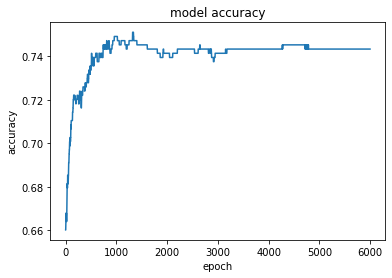

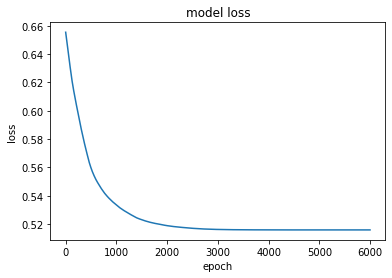

Size: 388.000000 bits - FPR: 1.000000 



Number of nodes: 2


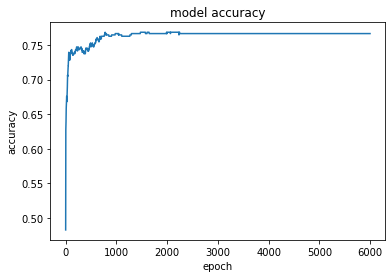

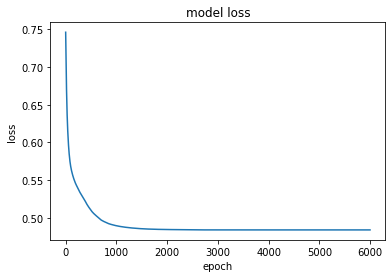

Size: 740.000000 bits - FPR: 0.704000 



Number of nodes: 3


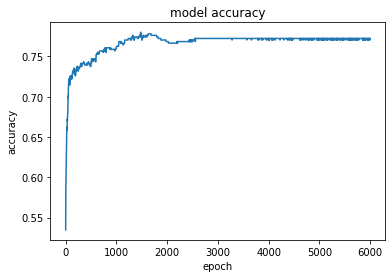

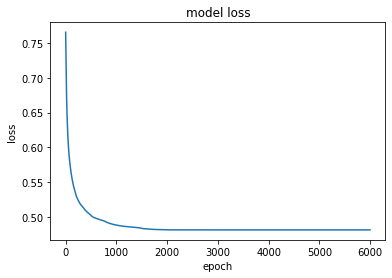

Size: 1092.000000 bits - FPR: 0.628000 



Number of nodes: 4


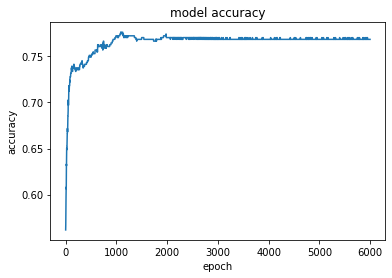

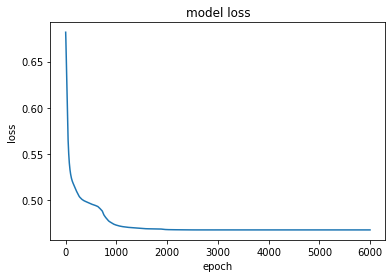

Size: 1444.000000 bits - FPR: 0.544000 



Number of nodes: 5


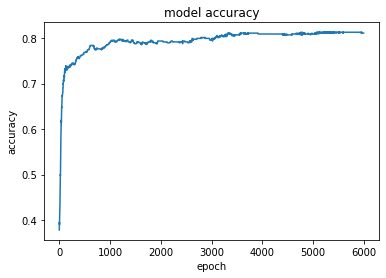

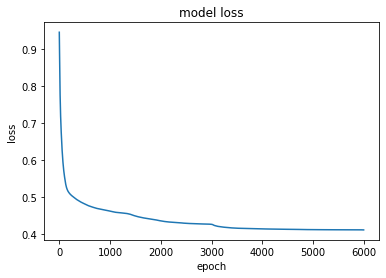

Size: 1796.000000 bits - FPR: 0.488000 



Number of nodes: 6


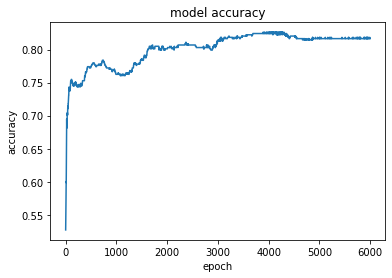

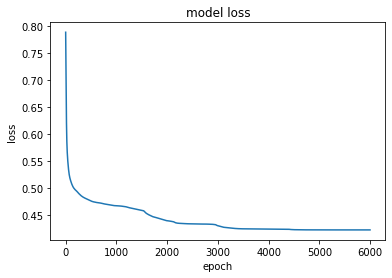

Size: 2148.000000 bits - FPR: 0.400000 



Number of nodes: 7


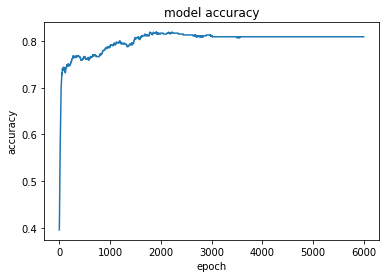

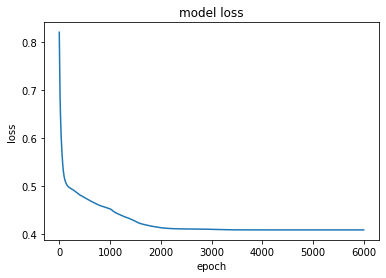

Size: 2500.000000 bits - FPR: 0.372000 



Number of nodes: 8


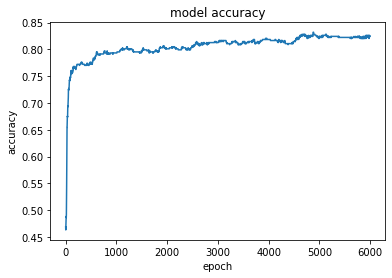

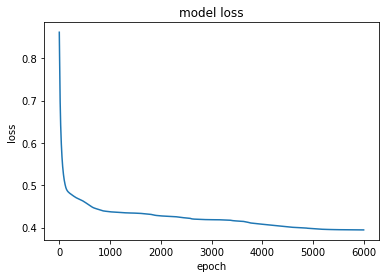

Size: 2852.000000 bits - FPR: 0.384000 



Number of nodes: 9


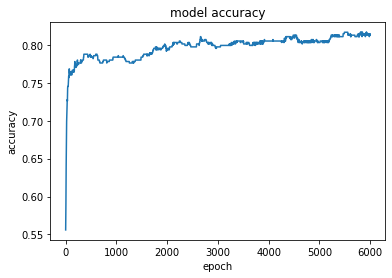

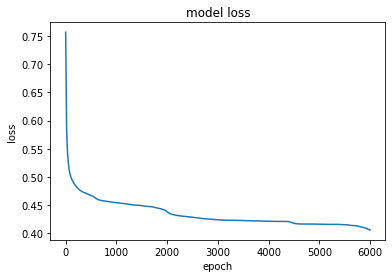

Size: 3204.000000 bits - FPR: 0.312000 



Number of nodes: 10


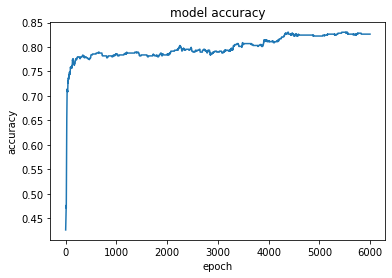

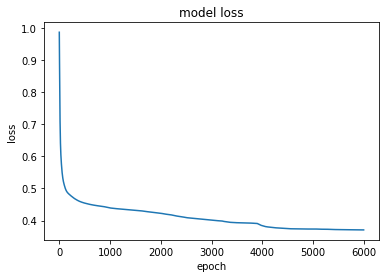

Size: 3556.000000 bits - FPR: 0.300000 



Number of nodes: 11


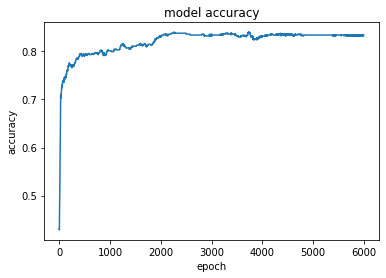

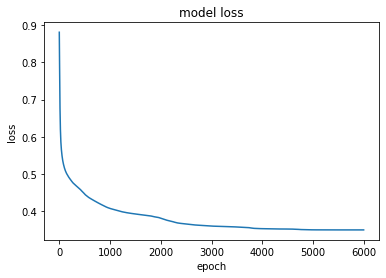

Size: 3908.000000 bits - FPR: 0.240000 



Number of nodes: 12


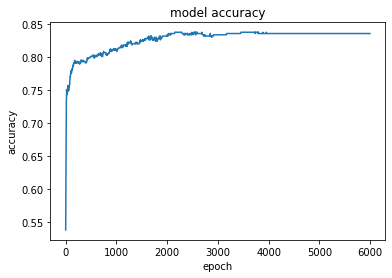

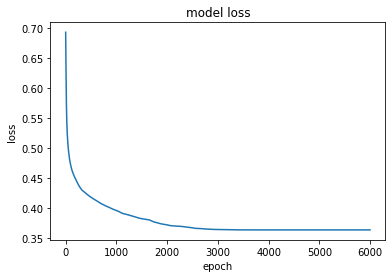

Size: 4260.000000 bits - FPR: 0.284000 



Number of nodes: 13


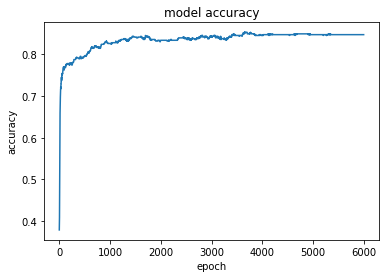

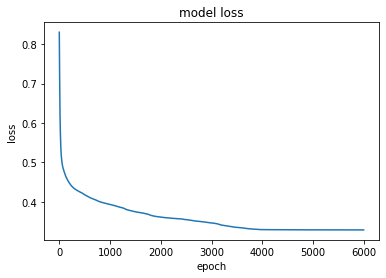

Size: 4612.000000 bits - FPR: 0.248000 



Number of nodes: 14


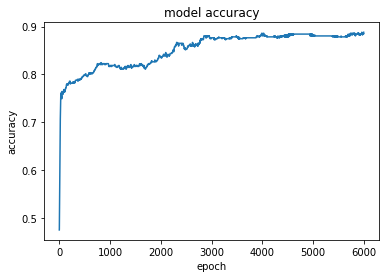

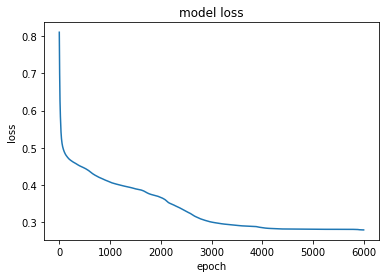

Size: 4964.000000 bits - FPR: 0.228000 



Number of nodes: 15


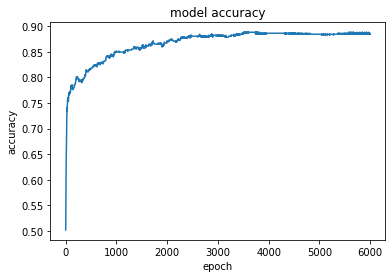

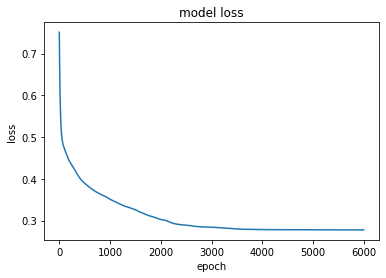

Size: 5316.000000 bits - FPR: 0.172000 



Number of nodes: 16


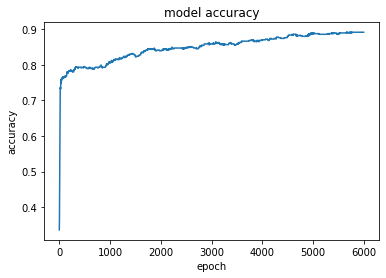

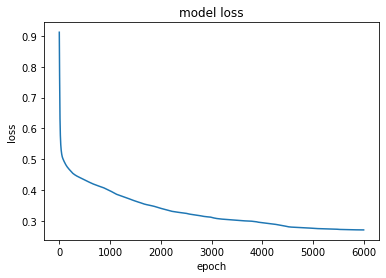

Size: 5668.000000 bits - FPR: 0.208000 



Number of nodes: 17


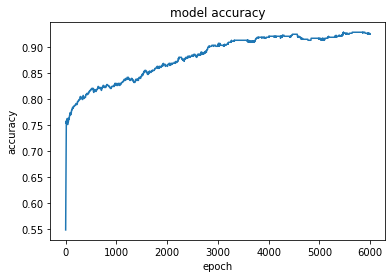

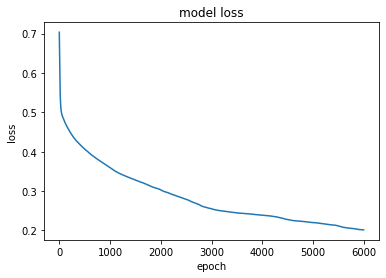

Size: 6020.000000 bits - FPR: 0.228000 



Number of nodes: 18


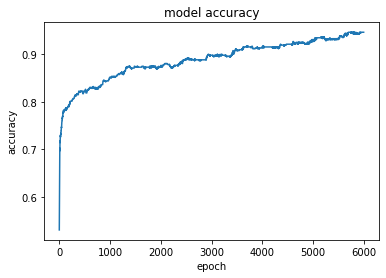

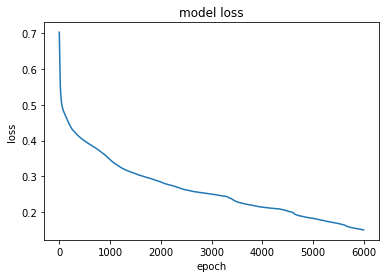

Size: 6372.000000 bits - FPR: 0.272000 



Number of nodes: 19


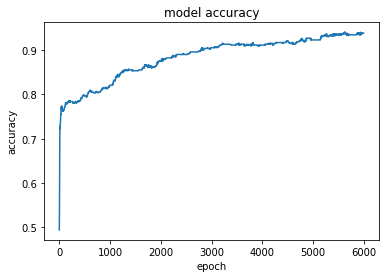

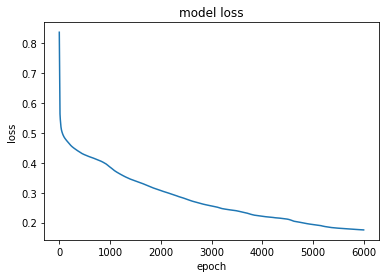

Size: 6724.000000 bits - FPR: 0.308000 



Number of nodes: 20


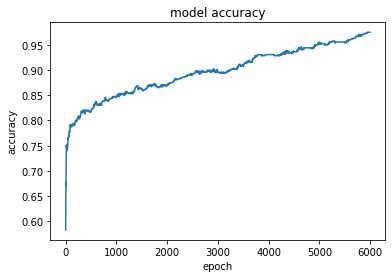

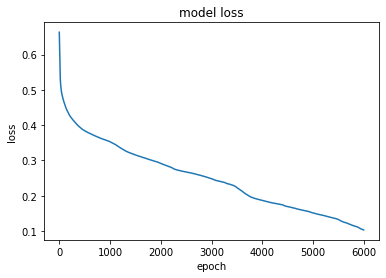

Size: 7076.000000 bits - FPR: 0.240000 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 1


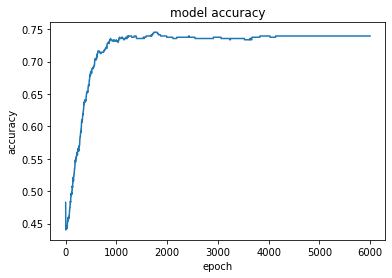

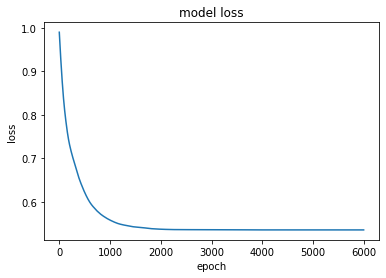

Size: 388.000000 bits - FPR: 0.960000 



Number of nodes: 2


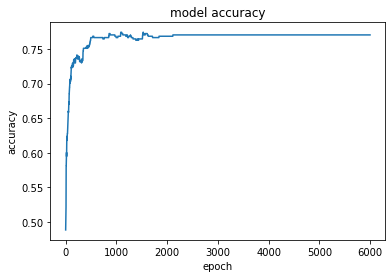

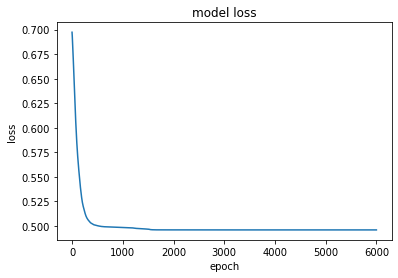

Size: 740.000000 bits - FPR: 0.740000 



Number of nodes: 3


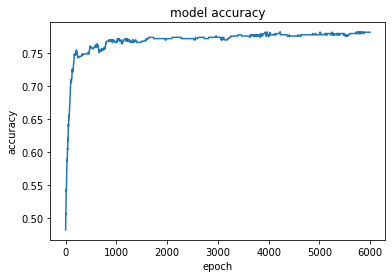

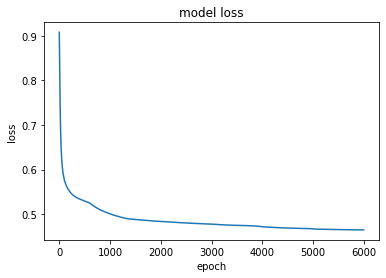

Size: 1092.000000 bits - FPR: 0.616000 



Number of nodes: 4


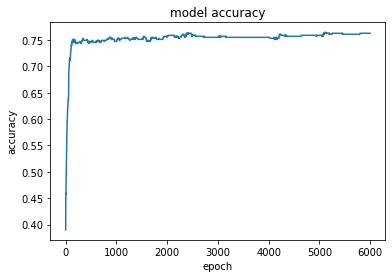

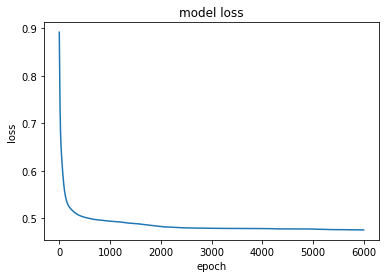

Size: 1444.000000 bits - FPR: 0.492000 



Number of nodes: 5


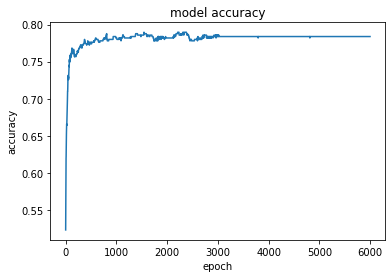

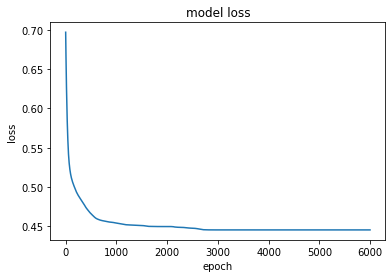

Size: 1796.000000 bits - FPR: 0.488000 



Number of nodes: 6


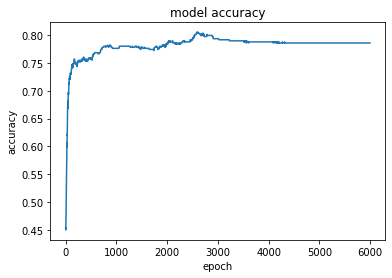

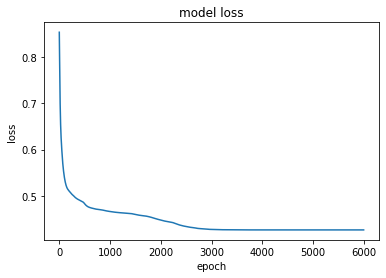

Size: 2148.000000 bits - FPR: 0.348000 



Number of nodes: 7


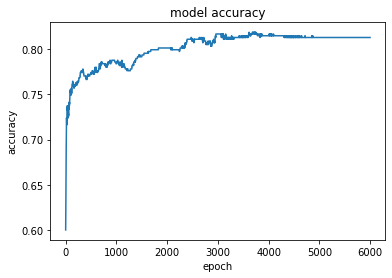

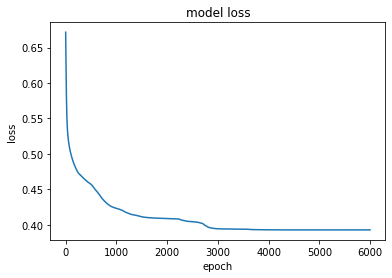

Size: 2500.000000 bits - FPR: 0.296000 



Number of nodes: 8


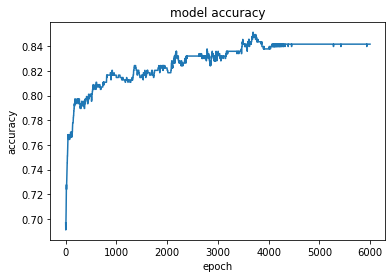

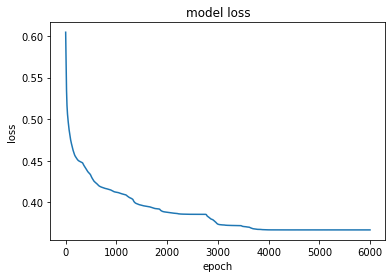

Size: 2852.000000 bits - FPR: 0.316000 



Number of nodes: 9


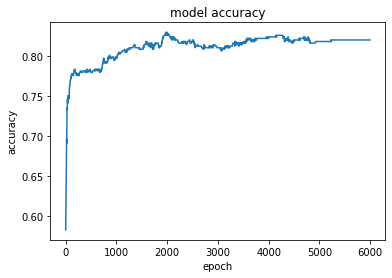

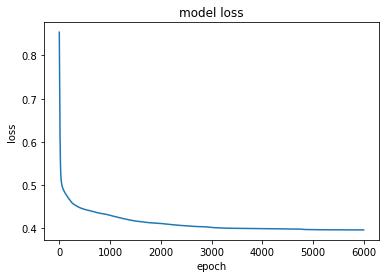

Size: 3204.000000 bits - FPR: 0.312000 



Number of nodes: 10


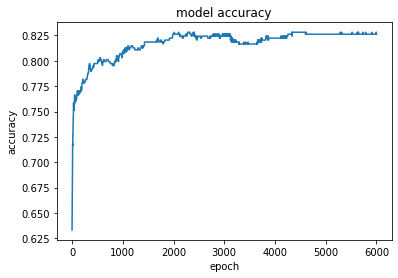

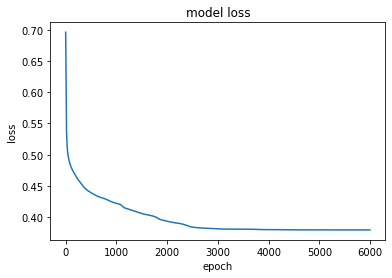

Size: 3556.000000 bits - FPR: 0.264000 



Number of nodes: 11


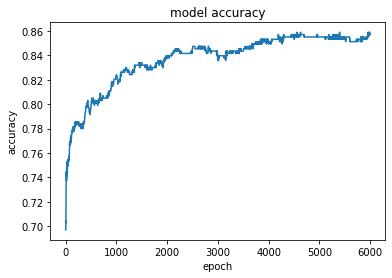

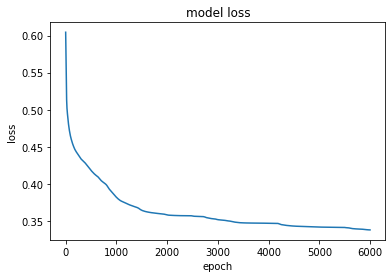

Size: 3908.000000 bits - FPR: 0.240000 



Number of nodes: 12


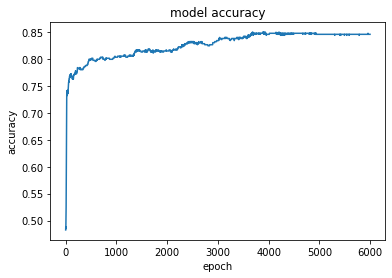

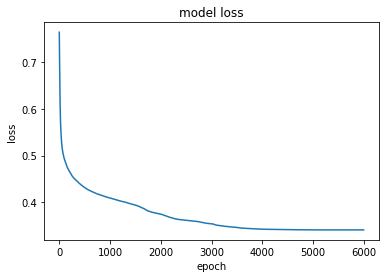

Size: 4260.000000 bits - FPR: 0.252000 



Number of nodes: 13


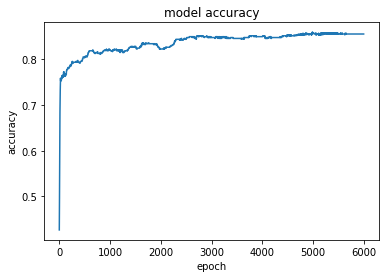

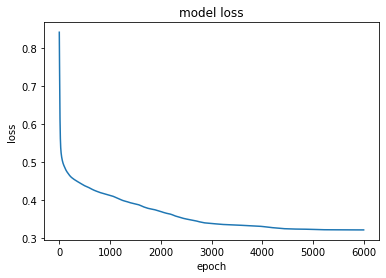

Size: 4612.000000 bits - FPR: 0.216000 



Number of nodes: 14


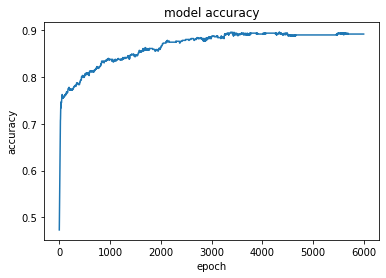

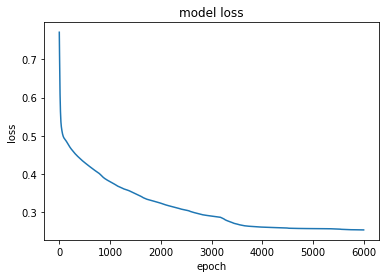

Size: 4964.000000 bits - FPR: 0.204000 



Number of nodes: 15


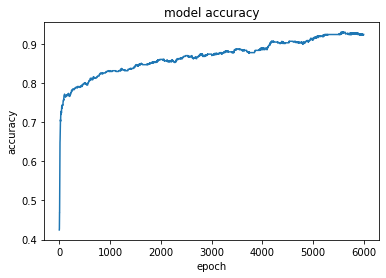

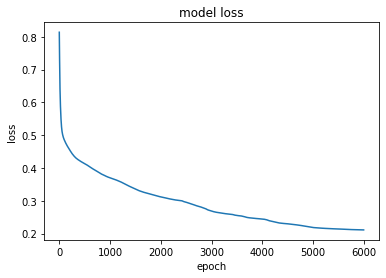

Size: 5316.000000 bits - FPR: 0.216000 



Number of nodes: 16


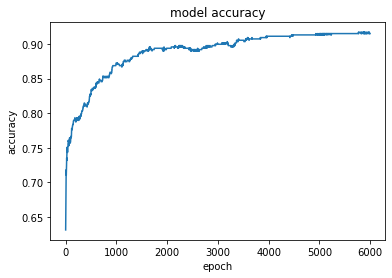

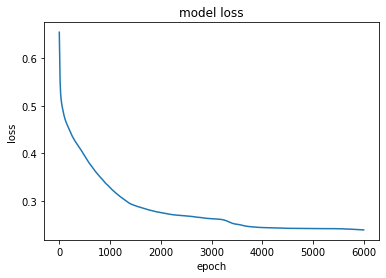

Size: 5668.000000 bits - FPR: 0.252000 



Number of nodes: 17


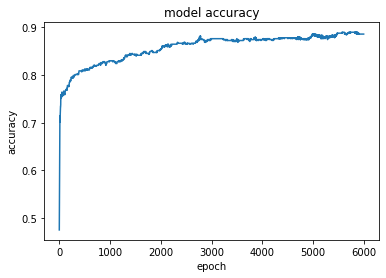

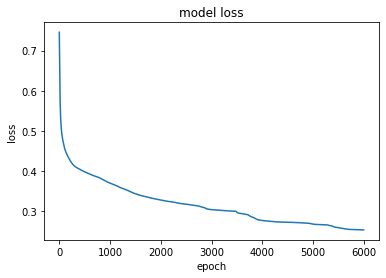

Size: 6020.000000 bits - FPR: 0.212000 



Number of nodes: 18


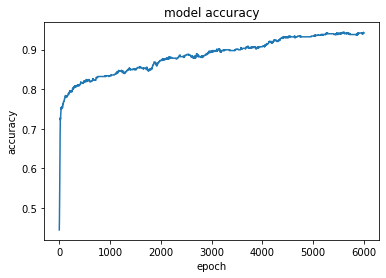

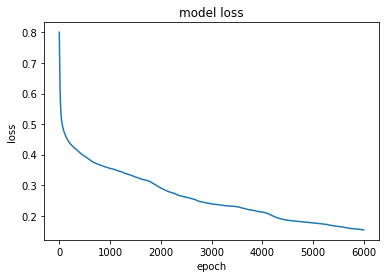

Size: 6372.000000 bits - FPR: 0.172000 



Number of nodes: 19


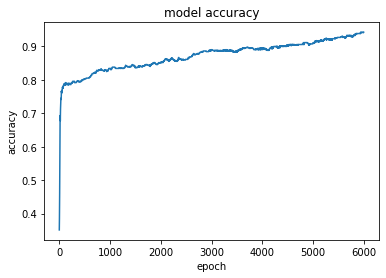

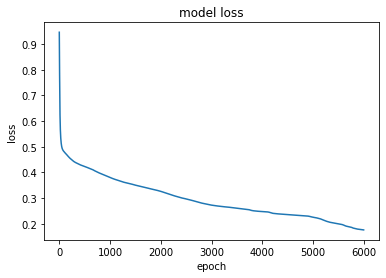

Size: 6724.000000 bits - FPR: 0.464000 



Number of nodes: 20


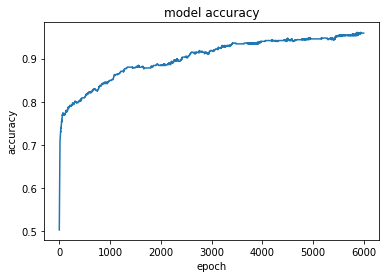

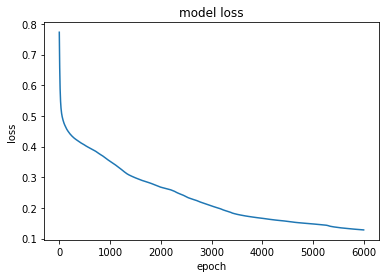

Size: 7076.000000 bits - FPR: 0.212000 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 1


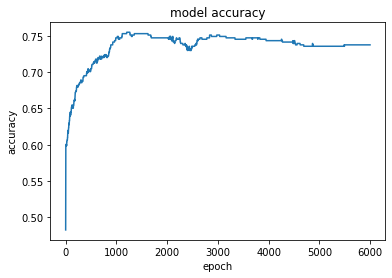

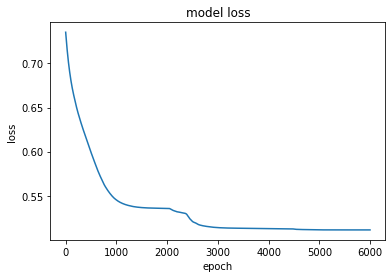

Size: 388.000000 bits - FPR: 0.952000 



Number of nodes: 2


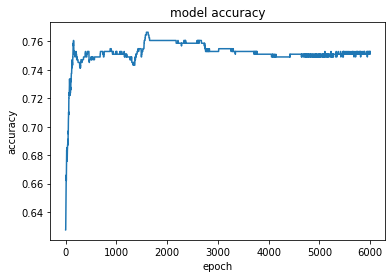

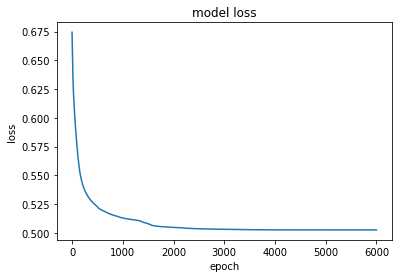

Size: 740.000000 bits - FPR: 0.764000 



Number of nodes: 3


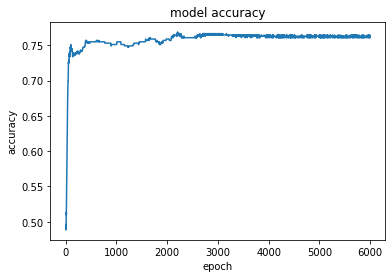

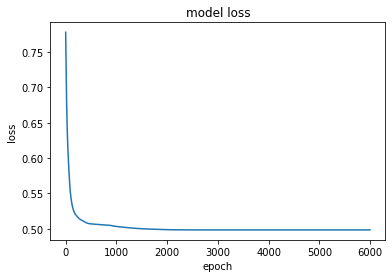

Size: 1092.000000 bits - FPR: 0.708000 



Number of nodes: 4


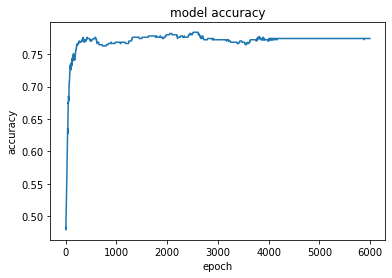

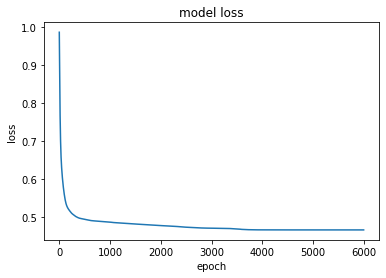

Size: 1444.000000 bits - FPR: 0.500000 



Number of nodes: 5


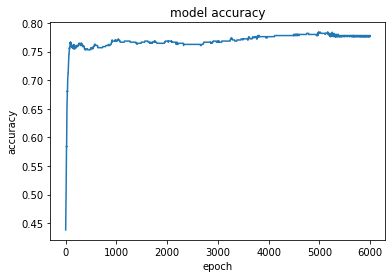

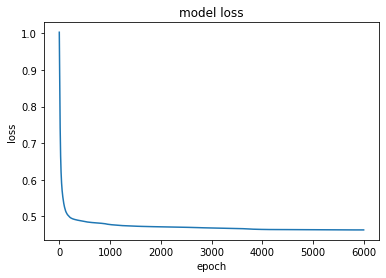

Size: 1796.000000 bits - FPR: 0.460000 



Number of nodes: 6


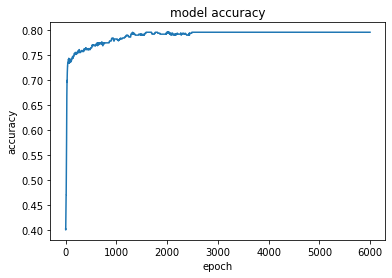

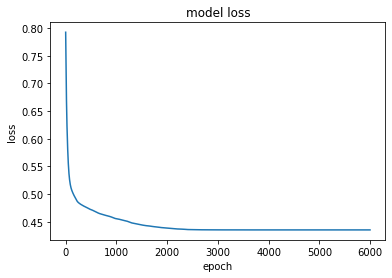

Size: 2148.000000 bits - FPR: 0.424000 



Number of nodes: 7


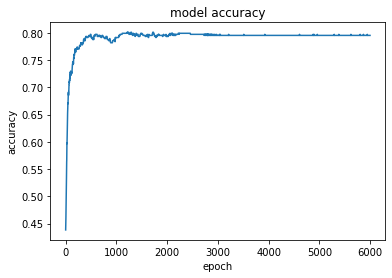

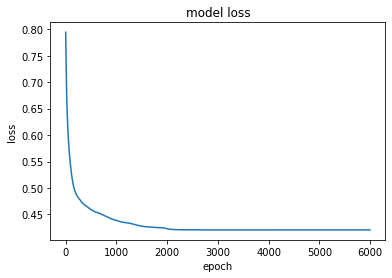

Size: 2500.000000 bits - FPR: 0.372000 



Number of nodes: 8


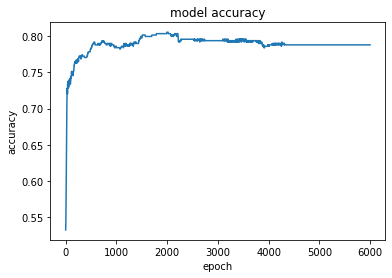

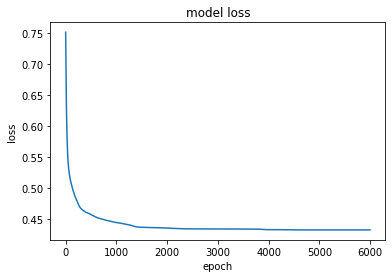

Size: 2852.000000 bits - FPR: 0.380000 



Number of nodes: 9


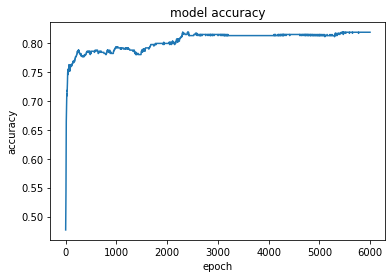

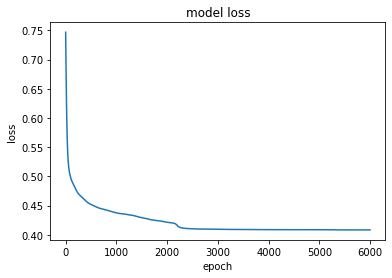

Size: 3204.000000 bits - FPR: 0.344000 



Number of nodes: 10


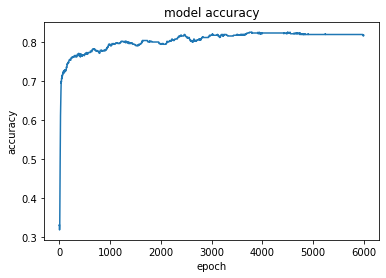

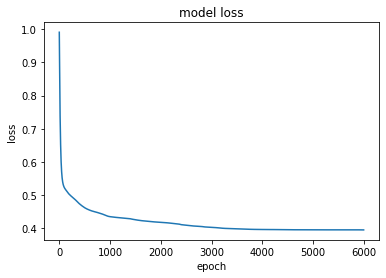

Size: 3556.000000 bits - FPR: 0.296000 



Number of nodes: 11


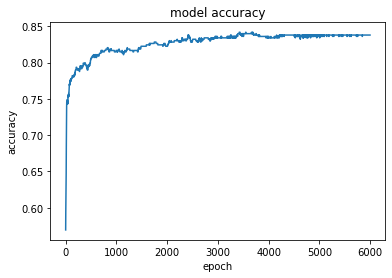

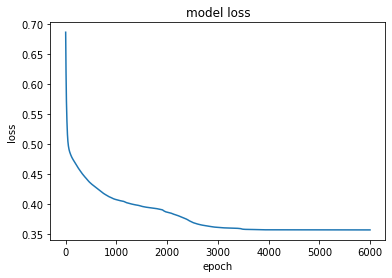

Size: 3908.000000 bits - FPR: 0.304000 



Number of nodes: 12


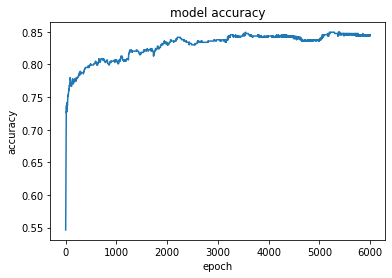

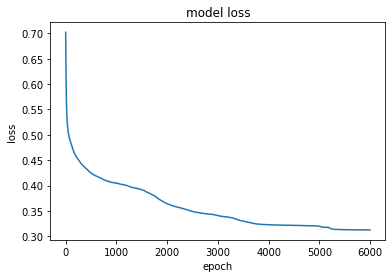

Size: 4260.000000 bits - FPR: 0.276000 



Number of nodes: 13


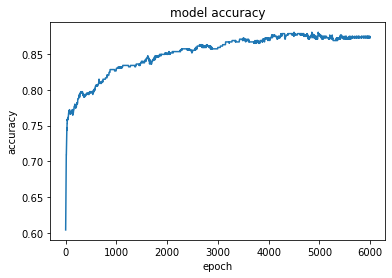

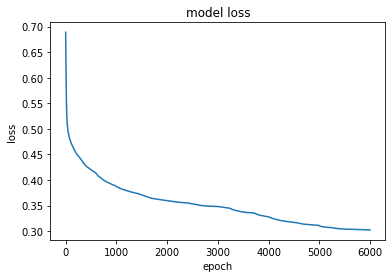

Size: 4612.000000 bits - FPR: 0.240000 



Number of nodes: 14


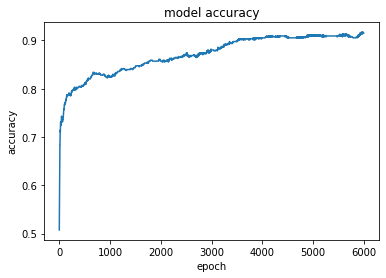

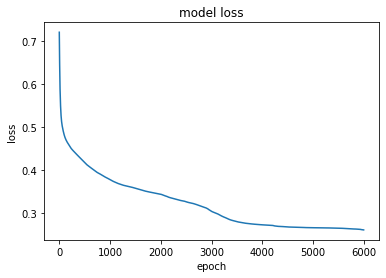

Size: 4964.000000 bits - FPR: 0.284000 



Number of nodes: 15


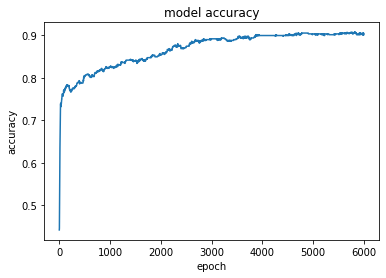

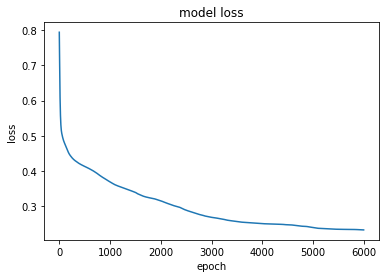

Size: 5316.000000 bits - FPR: 0.236000 



Number of nodes: 16


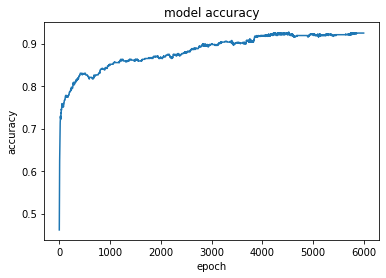

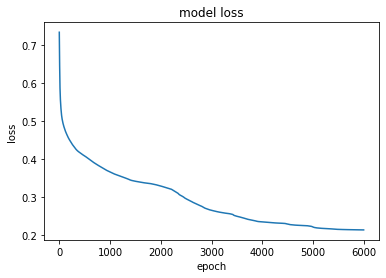

Size: 5668.000000 bits - FPR: 0.224000 



Number of nodes: 17


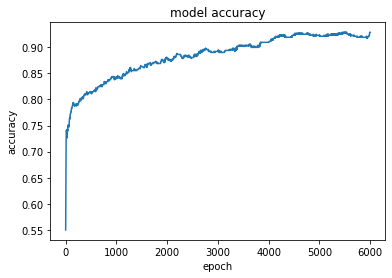

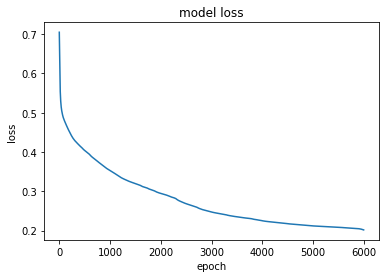

Size: 6020.000000 bits - FPR: 0.224000 



Number of nodes: 18


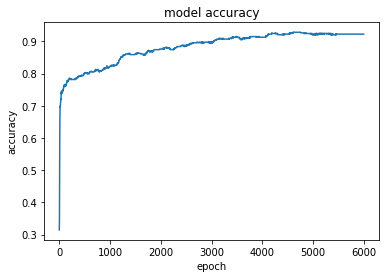

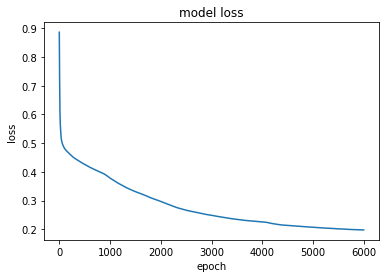

Size: 6372.000000 bits - FPR: 0.240000 



Number of nodes: 19


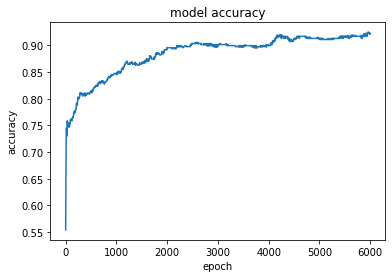

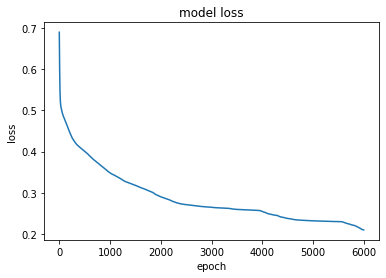

Size: 6724.000000 bits - FPR: 0.196000 



Number of nodes: 20


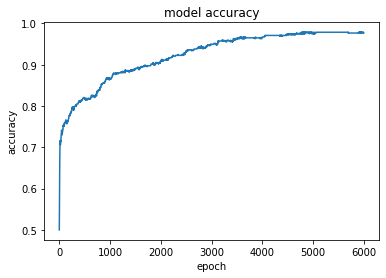

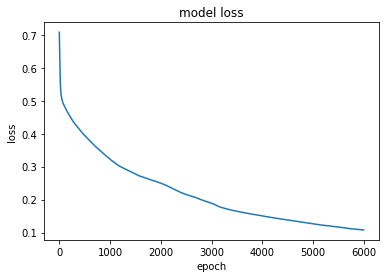

Size: 7076.000000 bits - FPR: 0.640000 





In [43]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,20,6000,fpr_values_kraska,size_values_kraska)

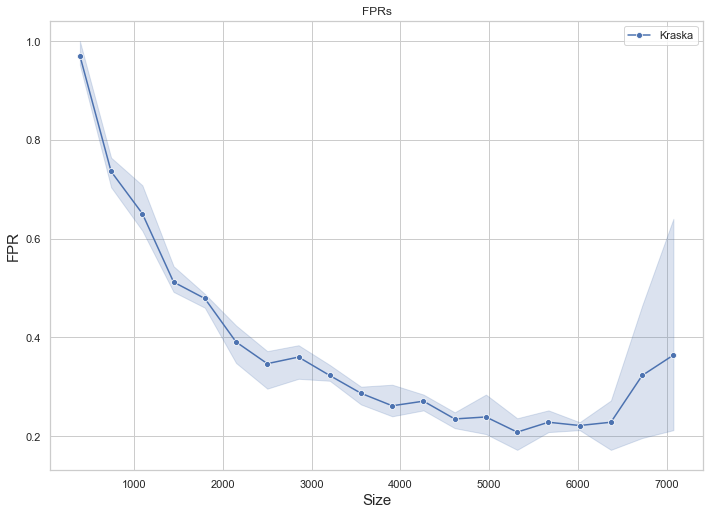

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection model

In [48]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [49]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [50]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

 



Size: 395 Bits - FPR: 0.460000 



Size: 405 Bits - FPR: 0.392000 



Size: 415 Bits - FPR: 0.416000 



Size: 425 Bits - FPR: 0.320000 



Size: 435 Bits - FPR: 0.364000 



Size: 445 Bits - FPR: 0.396000 



Size: 455 Bits - FPR: 0.348000 



Size: 465 Bits - FPR: 0.460000 



Size: 475 Bits - FPR: 0.380000 



Size: 485 Bits - FPR: 0.432000 



Size: 495 Bits - FPR: 0.344000 



Size: 505 Bits - FPR: 0.408000 



Size: 515 Bits - FPR: 0.336000 



Size: 525 Bits - FPR: 0.348000 



Size: 535 Bits - FPR: 0.356000 



Size: 545 Bits - FPR: 0.328000 



Size: 555 Bits - FPR: 0.312000 



Size: 565 Bits - FPR: 0.356000 



Size: 575 Bits - FPR: 0.332000 



Size: 585 Bits - FPR: 0.308000 



Size: 595 Bits - FPR: 0.288000 



Size: 605 Bits - FPR: 0.360000 



Size: 615 Bits - FPR: 0.292000 



Size: 625 Bits - FPR: 0.344000 



Size: 635 Bits - FPR: 0.324000 



Size: 645 Bits - FPR: 0.324000 



Size: 655 Bits - FPR: 0.272000 



Size: 665 Bits - FPR: 0.332000 



Size: 675 Bits 

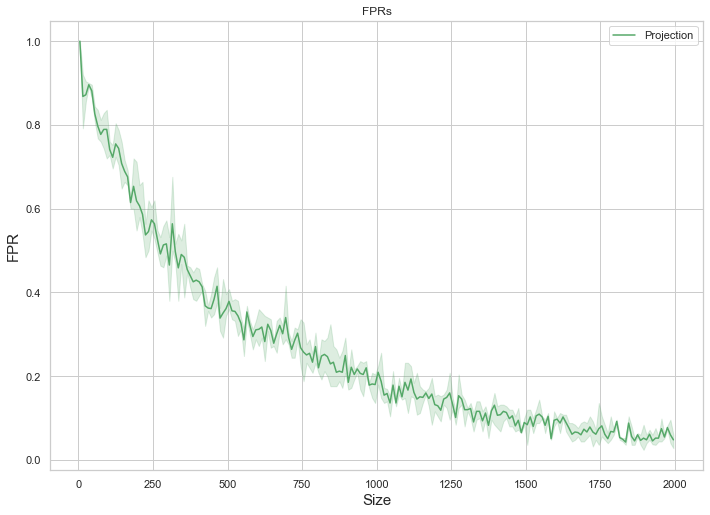

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Normal Bloom Filter Values

In [55]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [56]:
print(sum(y_train))
print(len(y_train))

268.0
518


In [57]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
268.0


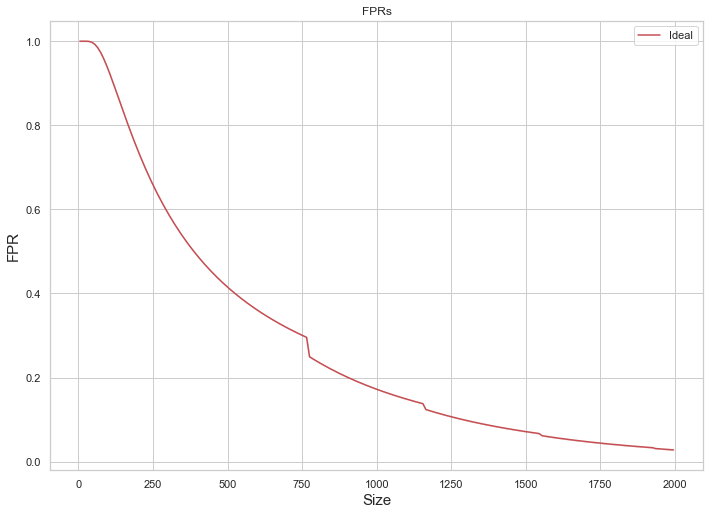

In [59]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

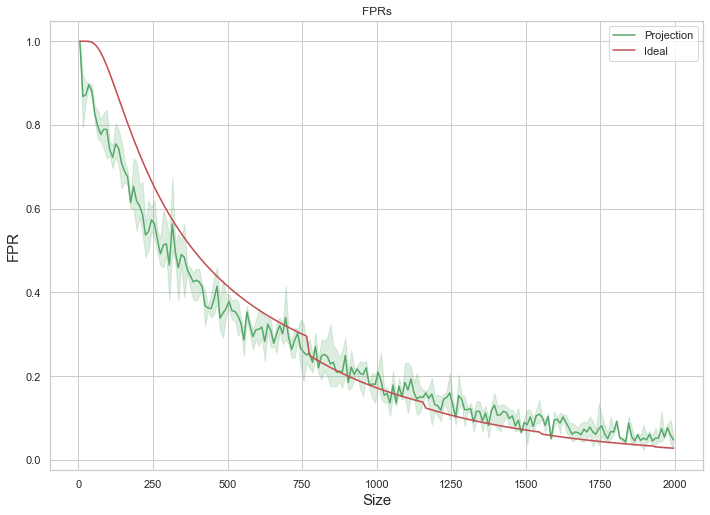

In [60]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [61]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

Size  Projection FPR  Ideal FPR
0     5           1.000   1.000000
1    15           0.920   1.000000
2    25           0.856   0.999982
3    35           0.896   0.999577
4    45           0.884   0.997577

In [62]:
df.to_csv('E:\SURA Data\Diabetes_Projection.csv')

# FPR Comparison between all 3 models

In [64]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [65]:
# Ran only once instead of thrice as size_values_kraska already has tripple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(268, 8)
Size: 388 Bits - FPR: 0.480000 



Size: 740 Bits - FPR: 0.248000 



Size: 1092 Bits - FPR: 0.156000 



Size: 1444 Bits - FPR: 0.136000 



Size: 1796 Bits - FPR: 0.044000 



Size: 2148 Bits - FPR: 0.052000 



Size: 2500 Bits - FPR: 0.024000 



Size: 2852 Bits - FPR: 0.020000 



Size: 3204 Bits - FPR: 0.012000 



Size: 3556 Bits - FPR: 0.000000 



Size: 3908 Bits - FPR: 0.004000 



Size: 4260 Bits - FPR: 0.000000 



Size: 4612 Bits - FPR: 0.008000 



Size: 4964 Bits - FPR: 0.004000 



Size: 5316 Bits - FPR: 0.004000 



Size: 5668 Bits - FPR: 0.000000 



Size: 6020 Bits - FPR: 0.000000 



Size: 6372 Bits - FPR: 0.000000 



Size: 6724 Bits - FPR: 0.000000 



Size: 7076 Bits - FPR: 0.000000 



Size: 388 Bits - FPR: 0.448000 



Size: 740 Bits - FPR: 0.284000 



Size: 1092 Bits - FPR: 0.172000 



Size: 1444 Bits - FPR: 0.096000 



Size: 1796 Bits - FPR: 0.072000 



Size: 2148 Bits - FPR: 0.048000 



Size: 2500 Bits - FPR: 0.040000 



Size: 2852 Bits - FPR: 

In [66]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)

60
268.0


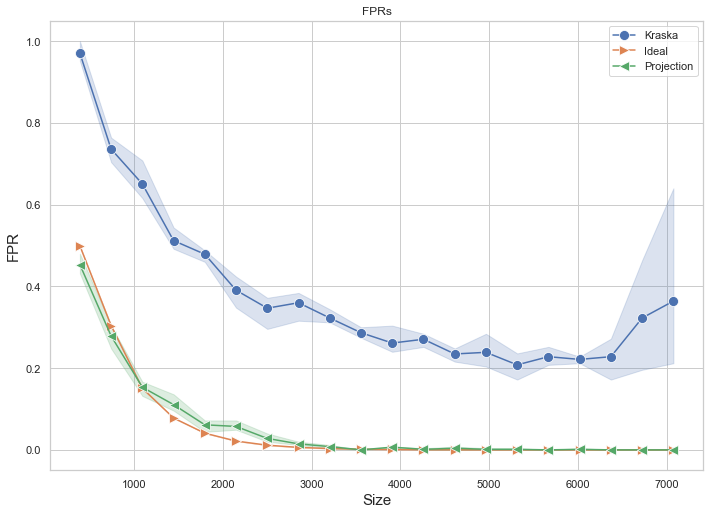

In [67]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [68]:
saved_data = list(zip(size_values_kraska, fpr_values_kraska,fpr_values_projection, y_ideal_k))
df = pd.DataFrame(saved_data,columns = ['Size','Kraska FPR', 'Projection FPR', 'Ideal FPR'])
df.head()

Size  Kraska FPR  Projection FPR  Ideal FPR
0   388       1.000           0.480   0.499232
1   740       0.704           0.248   0.304001
2  1092       0.628           0.156   0.150565
3  1444       0.544           0.136   0.077889
4  1796       0.488           0.044   0.040848

In [69]:
df.to_csv('E:\SURA Data\Diabetes_Kraska_Projection.csv')

# Projection Model with only 1 Hash Function

In [70]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = 1  #Setting k as 1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [71]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

 



Size: 395 Bits - FPR: 0.440000 



Size: 405 Bits - FPR: 0.412000 



Size: 415 Bits - FPR: 0.380000 



Size: 425 Bits - FPR: 0.468000 



Size: 435 Bits - FPR: 0.480000 



Size: 445 Bits - FPR: 0.336000 



Size: 455 Bits - FPR: 0.340000 



Size: 465 Bits - FPR: 0.312000 



Size: 475 Bits - FPR: 0.472000 



Size: 485 Bits - FPR: 0.396000 



Size: 495 Bits - FPR: 0.348000 



Size: 505 Bits - FPR: 0.344000 



Size: 515 Bits - FPR: 0.344000 



Size: 525 Bits - FPR: 0.368000 



Size: 535 Bits - FPR: 0.420000 



Size: 545 Bits - FPR: 0.336000 



Size: 555 Bits - FPR: 0.300000 



Size: 565 Bits - FPR: 0.304000 



Size: 575 Bits - FPR: 0.336000 



Size: 585 Bits - FPR: 0.256000 



Size: 595 Bits - FPR: 0.396000 



Size: 605 Bits - FPR: 0.276000 



Size: 615 Bits - FPR: 0.272000 



Size: 625 Bits - FPR: 0.316000 



Size: 635 Bits - FPR: 0.276000 



Size: 645 Bits - FPR: 0.280000 



Size: 655 Bits - FPR: 0.312000 



Size: 665 Bits - FPR: 0.384000 



Size: 675 Bits 

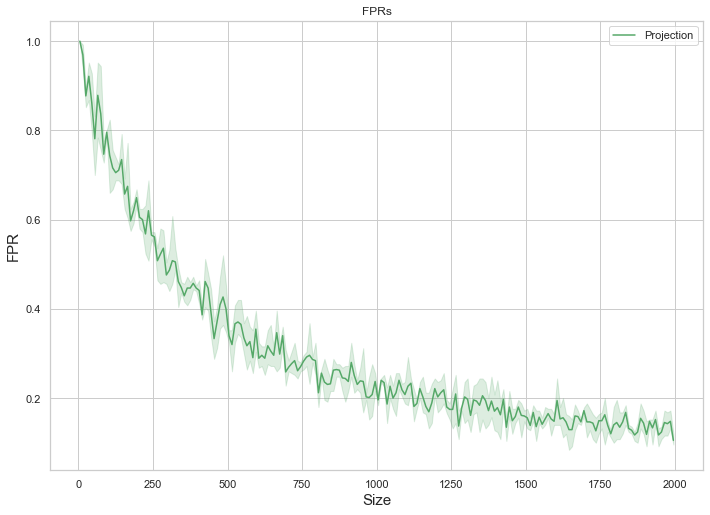

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Comparing new Projection Model with Ideal Bloom Filter

In [73]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
268.0


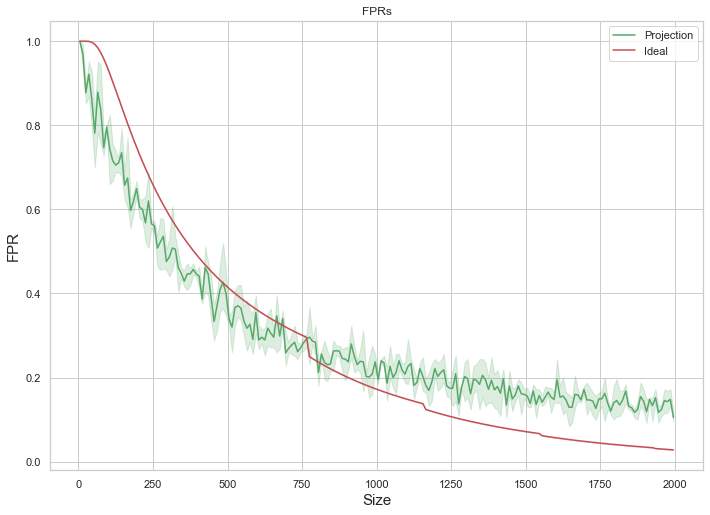

In [74]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [75]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

Size  Projection FPR  Ideal FPR
0     5           1.000   1.000000
1    15           0.980   1.000000
2    25           0.852   0.999982
3    35           0.868   0.999577
4    45           0.796   0.997577

In [76]:
df.to_csv('E:\SURA Data\Diabetes_Projection1Hash.csv')

# Giving independent bitarrays for each hash function in Projection Model

In [77]:
class Projection_Multiple_Array_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1    
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = (size//hash_count) # Size of each bitarray
        self.hash_count = hash_count
        arrays = []
        for i in range(0,hash_count):
            array = bitarray(size//hash_count)
            array.setall(0)
            arrays += [array]
        self.bit_arrays = arrays

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
            
    def lookup(self, x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values[0])):
            for j in range(0,self.hash_count):
                if(self.bit_arrays[j][int(hash_values[i][j])] == 0):
                    return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(pos_hash_values)):
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(pos_hash_values[i][j])] == 0):
                return -1
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [78]:
def get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [79]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,5,10,200,100,fpr_values,size_values)

 



Size: 395 Bits - FPR: 0.384000 



Size: 405 Bits - FPR: 0.432000 



Size: 415 Bits - FPR: 0.432000 



Size: 425 Bits - FPR: 0.388000 



Size: 435 Bits - FPR: 0.432000 



Size: 445 Bits - FPR: 0.440000 



Size: 455 Bits - FPR: 0.288000 



Size: 465 Bits - FPR: 0.340000 



Size: 475 Bits - FPR: 0.472000 



Size: 485 Bits - FPR: 0.360000 



Size: 495 Bits - FPR: 0.364000 



Size: 505 Bits - FPR: 0.344000 



Size: 515 Bits - FPR: 0.392000 



Size: 525 Bits - FPR: 0.344000 



Size: 535 Bits - FPR: 0.368000 



Size: 545 Bits - FPR: 0.280000 



Size: 555 Bits - FPR: 0.344000 



Size: 565 Bits - FPR: 0.300000 



Size: 575 Bits - FPR: 0.376000 



Size: 585 Bits - FPR: 0.332000 



Size: 595 Bits - FPR: 0.360000 



Size: 605 Bits - FPR: 0.300000 



Size: 615 Bits - FPR: 0.292000 



Size: 625 Bits - FPR: 0.256000 



Size: 635 Bits - FPR: 0.356000 



Size: 645 Bits - FPR: 0.336000 



Size: 655 Bits - FPR: 0.320000 



Size: 665 Bits - FPR: 0.304000 



Size: 675 Bits 

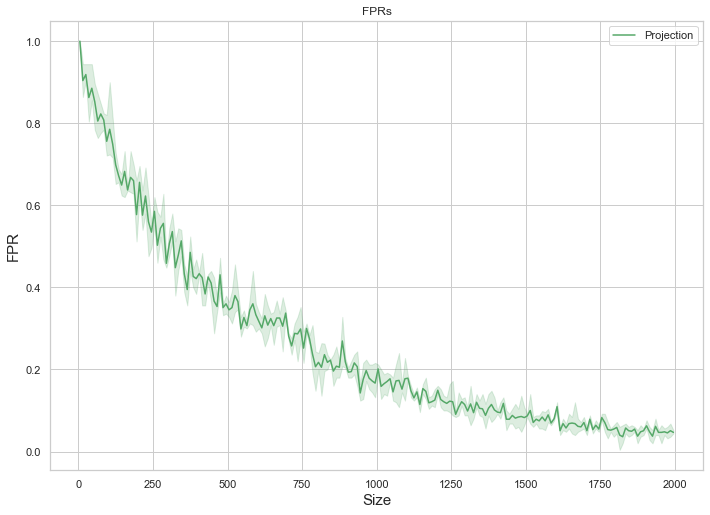

In [80]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [81]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
268.0


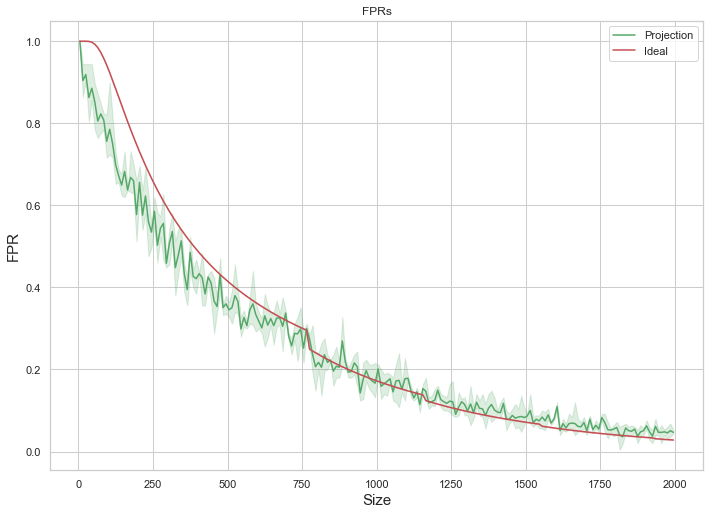

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [83]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()
df.to_csv('E:\SURA Data\Diabetes_ProjectionDiffBitarrays.csv')